In [2]:
import time, enum, math
import panel as pn
from panel import widgets as pnw
import random
import numpy as np
from numpy.random import choice
import pandas as pd
import pylab as plt
import networkx as nx
import itertools
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import bokeh.palettes
from bokeh.plotting import figure, show
from bokeh.models import Legend, LegendItem, ColumnDataSource, Grid, Line, LinearAxis, Plot
from sklearn import preprocessing
import copy
from IPython.display import display
from ipywidgets import FloatSlider, IntSlider
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import statistics

### General functions

In [3]:
def model_data(model):
    '''retrieve data of model'''
    data = model.datacollector.get_model_vars_dataframe()
    data = data.reset_index()
    data = data.rename(columns={'index':'Step'})
    data = data.set_index('Step')
    return data

def agent_data(model):
    '''retrieve data of agents (strategies)'''
    data = model.datacollector.get_agent_vars_dataframe()
    data = data.reset_index()
    return data

def competitive_selection(choices, model, own_node_nr):
    '''tournament selection of neighbor'''
    if len(choices) >= 3:
        top_3_nbs = random.sample(choices, 3)
        their_weights = [model.G[nb][own_node_nr]['weight'] for nb in top_3_nbs]
        nec_dict = {k:v for k,v in zip(top_3_nbs,their_weights)}
        nec_dict_sorted = dict(sorted(nec_dict.items(), key=lambda item: item[1]))
        if choice(['y','n'], 1, p=[0.5,0.5])[0] == 'y':
            return [list(nec_dict_sorted.keys())[0]]
        elif choice(['y','n'], 1, p=[0.5*(1-0.5),1-(0.5*(1-0.5))])[0] == 'y':
            return [list(nec_dict_sorted.keys())[1]]
        else:
            return [list(nec_dict_sorted.keys())[2]]
    elif len(choices) == 2:
        their_weights = [model.G[nb][own_node_nr]['weight'] for nb in choices]
        nec_dict = {k:v for k,v in zip(choices,their_weights)}
        nec_dict_sorted = dict(sorted(nec_dict.items(), key=lambda item: item[1]))
        if choice(['y','n'], 1, p=[0.5,0.5])[0] == 'y':
            return [list(nec_dict_sorted.keys())[0]]
        else:
            return [list(nec_dict_sorted.keys())[1]]
    elif len(choices) == 1:
        return [choices[0]]
    else:
        return []

def wealth_dist(model):
    '''calculate how much wealth the wealthies 20% owns'''
    agents_wealth = {}
    # create dict with agent:total wealth pairs
    for agent in model.schedule.agents:
        agents_wealth[agent.unique_id] = agent.wealth
    # sort dictionary
    sorted_wealths = dict(sorted(agents_wealth.items(), key=lambda item: item[1], reverse=True))
    # wealthiest 20% of population (rounded up)
    elite_quantity = math.ceil(len(sorted_wealths)/5)
    # wealth in hands of top 20% of population
    wealth_q = sum(dict(itertools.islice(sorted_wealths.items(), elite_quantity)).values())
    # percentages
    if sum(sorted_wealths.values()) != 0:
        wealth_perc = wealth_q/sum(sorted_wealths.values())
        return round(wealth_perc*100,2)
    else:
        return 20

def run_economic_model(runs, fill_val,nr_steps,N,wealth_falloff,mab,defect_payoff,update_prob,inter_threshold, enforcement_prob, nb_parameter):
    '''run the plant propagation model with user-given parameter values and nr of runs'''
    store_results = []
    for _ in range(runs):              
        model = WealthModel(N,wealth_falloff,mab,defect_payoff,update_prob,inter_threshold, enforcement_prob, nb_parameter)
        model.datacollector.collect(model)
        for i in range(nr_steps):
            model.step()

        run_results_y = list(model_data(model).iloc[:,0])
        store_results.append(run_results_y)
  
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(6)
    
    # print the lines of the multiple runs
    if fill_val == 'lines' or runs == 1:
        for run_results_yy in store_results:
            plt.plot([*range(0, nr_steps+1, 1)],run_results_yy,linewidth=3)
    # shade between the upper and lowerbound of the multiple runs, show mean and stdev
    else:
        means = []
        stdevs = []
        minima = []
        maxima = []
        for item in zip(*store_results):
            means.append(statistics.mean(list(item)))
            stdevs.append(statistics.stdev(list(item)))
            minima.append(min(item))
            maxima.append(max(item))
        plt.fill_between([*range(0, nr_steps+1, 1)], minima,maxima,color='k',alpha=.3, label='range of values')
        plt.errorbar([*range(0, nr_steps+1, 1)], means, stdevs, marker='.', label='\u03BC and \u03C3')

    plt.xticks([0,*range(10, nr_steps+1, 10)])
    plt.yticks([*range(0, 101, 10)])
    plt.ylabel('% of wealth')
    plt.xlabel('Step')
    plt.title('% of wealth owned by wealthiest 20% of agents per step in model ({} runs)'.format(runs))
    plt.legend()
    plt.show()
    
    # plot strategies ratio
    if runs == 1:        
        f = plt.figure()
        f.set_figwidth(10)
        f.set_figheight(6)
        ratios = []
        strats = agent_data(model)
        for step in range(nr_steps+1):
            coops_thisstep = list(strats.loc[strats['Step'] == step]['strategy']).count('C')
            defects_thisstep = list(strats.loc[strats['Step'] == step]['strategy']).count('D')
            if defects_thisstep != 0:
                ratios.append(coops_thisstep/defects_thisstep)
            else:
                ratios.append(coops_thisstep)
        plt.plot([*range(0, nr_steps+1, 1)], ratios, linewidth=3)
        plt.ylabel('Ratio C/D')
        plt.xlabel('Step')
        plt.xticks([0,*range(10, nr_steps+1, 10)])
        plt.title('Ratio: number of cooperators over number of defectors (C/D) per step')
        plt.legend()
        plt.show()
    
def parameter_space_economic_model(runs,nr_steps,N,wealth_falloff,mab,defect_payoff,update_prob,inter_threshold, enforcement_prob, nb_parameter):
    '''test the individual parameters'''
    args = locals()
    del args['runs']
    argsCOPY = copy.deepcopy(args)
    all_runs = []
    for _ in range(runs):
        results = []
        x_axis = [v for v in args.values() if type(v) == list][0]
        param_name = [k for k,v in args.items() if type(v) == list][0]
        al = [v for v in args.values()]    
        for j in range(len(x_axis)):
            inputt = []
            for i in al:
                if type(i) == list:
                    inputt.append(i[j])
                else:
                    inputt.append(i)

            model = WealthModel(*inputt[1:])
            for _ in range(inputt[0]):
                model.step()
            percentage = model_data(model).iloc[-1][0]
            results.append(percentage)
        all_runs.append(results)
    
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(6)
    
    means = []
    stdevs = []
    maxima = []
    minima = []
    # if param values are cardinal
    if type(x_axis[0]) == int or type(x_axis[0]) == float:
        for item in zip(*all_runs):
            means.append(statistics.mean(list(item)))
            stdevs.append(statistics.stdev(list(item)))
            minima.append(min(item))
            maxima.append(max(item))
        # plot range of vals, mean, stdev
        plt.fill_between(x_axis, minima, maxima,color='k',alpha=.2)
        plt.errorbar(x_axis, means, stdevs, marker='o')
        
    else:
        for item in zip(*all_runs):
            means.append(statistics.mean(list(item)))
            stdevs.append(statistics.stdev(list(item)))
        # plot barplot
        plt.bar(x_axis, means, label='\u03BC')
        plt.errorbar(x_axis, means, stdevs, marker='.', linestyle='None', color='black')
    
    plt.xlabel(f'{param_name} parameter')
    plt.ylabel('% of wealth')
    plt.title('% of wealth owned by wealthies 20% of agents per parameter value (avg. over {} runs; {} steps per run)'.format(runs,nr_steps))
    plt.xticks(x_axis)
    plt.yticks([*range(0,110,10)])
    plt.legend()
    plt.show()

### Class for agents

In [4]:
class EconomicAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.strategy = choice(['C','D'], 1, p=[.5,.5])[0]
        self.wealth = 1
        self.payoff = 0
        
    def interact(self):
        
        nbs_agents = self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(self.pos, include_center=False))
        distances = [self.model.G[self.unique_id][nb.pos]['weight'] for nb in nbs_agents] 
        
        # only 1 neighbor
        if self.model.nb_parameter == 1 and len(nbs_agents) > 0:
            nbs_agents = [random.choice(nbs_agents)]
            distances = [self.model.G[self.unique_id][nbs_agents[0].pos]['weight']]
            
        # competitive selection
        elif self.model.nb_parameter == 2:
            nbs = competitive_selection(self.model.grid.get_neighbors(self.pos, include_center=False), self.model, self.pos)
            distances = [self.model.G[self.unique_id][nbs[0]]['weight']]
            nbs_agents = self.model.G.nodes[nbs[0]]['agent']
            
        # random fraction of neighbors
        elif self.model.nb_parameter == 3:
            nbs_agents = random.sample(nbs_agents, random.randrange(0,len(nbs_agents)+1))
            distances = [self.model.G[self.unique_id][nb.pos]['weight'] for nb in nbs_agents]
        
        for nb, distance in zip(nbs_agents, distances):
            # if edge weight is smaller or equal to interaction threshold and if this edge was not already used this round
            if distance < self.model.interaction and self.unique_id not in self.model.interacted[nb.unique_id]:
                
                # store that this edge has now been used this round
                self.model.interacted[self.unique_id].append(nb.unique_id) 
                
                #payoffs
                if self.strategy == 'C' and nb.strategy == 'C':
                    self.payoff += 1
                    self.wealth += 1
                    nb.payoff += 1
                    nb.wealth += 1

                elif self.strategy == 'D' and nb.strategy == 'D':
                    self.payoff += 0
                    self.wealth += 0
                    nb.payoff += 0
                    nb.wealth += 0

                elif self.strategy == 'C' and nb.strategy == 'D':
                    # if enforcement does not take place
                    if choice([0,1], 1, p=[self.model.enforcement_prob,1-self.model.enforcement_prob])[0] == 1:
                        self.payoff += 0
                        self.wealth += 0
                        nb.payoff += self.model.defect_payoff 
                        nb.wealth += self.model.defect_payoff
                        
                    # if enforcement takes place
                    else:
                        self.payoff += self.model.defect_payoff
                        self.wealth += self.model.defect_payoff
                        nb.payoff += 0
                        nb.wealth += 0

                elif self.strategy == 'D' and nb.strategy == 'C':
                    # if enforcement does not take place
                    if choice([0,1], 1, p=[self.model.enforcement_prob,1-self.model.enforcement_prob])[0] == 1:
                        self.payoff += self.model.defect_payoff
                        self.wealth += self.model.defect_payoff
                        nb.payoff += 0
                        nb.wealth += 0
                        
                    # if enforcement takes place
                    else:
                        self.payoff += 0
                        self.wealth += 0
                        nb.payoff += self.model.defect_payoff
                        nb.wealth += self.model.defect_payoff

    def update_strat(self):
        '''agents update their strategy based on most successful neighbor'''
        if choice([0,1], 1, p=[1-self.model.update_prob,self.model.update_prob])[0] == 1:
            # get neighbors and their successes that round
            neighbors = self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(self.pos, include_center=False))
            successes = [((1-self.model.alpha) * a.wealth + self.model.alpha * a.payoff) for a in neighbors]
            # if a neighbor was more successful than this agent, copy strategy
            if max(successes) > ((1-self.model.alpha) * self.wealth + self.model.alpha * self.payoff):
                self.strategy = neighbors[successes.index(max(successes))].strategy
                    
    def step(self):
        self.interact()

### Class for model

In [5]:
class WealthModel(Model):

    def __init__(self, N, wealth_falloff, mab, defect_payoff, update_prob, interaction_threshold, enforcement_prob, nb_parameter):
        self.G = nx.barabasi_albert_graph(N,mab)  
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.num_agents = N
        
        for u, v in self.G.edges():
            # add random weights between 0 and 1
            self.G[u][v]["weight"] = random.random()
            
        # parameters
        # how much does the total wealth count for the payoff
        self.alpha = wealth_falloff
        # how much does defecting give as payoff against cooperation
        self.defect_payoff = defect_payoff
        # edge weight threshold for interaction
        self.interaction = interaction_threshold
        # probability for an agent to update learning strategy
        self.update_prob = update_prob
        # interacting with random nb, random fraction, or all nbs
        if nb_parameter == 'one':
            self.nb_parameter = 1
        elif nb_parameter == 'competitive one':
            self.nb_parameter = 2
        elif nb_parameter == 'fraction':
            self.nb_parameter = 3
        else:
            self.nb_parameter = 4
        # probability that enforcement occurs in CD or DC situations
        self.enforcement_prob = enforcement_prob
            
        # create agents
        for i, node in enumerate(sorted(self.G.nodes())):
            a = EconomicAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, node)
        
        self.datacollector = DataCollector(   
                             model_reporters= {"% of wealth owned by wealthiest 20%": wealth_dist},
                             agent_reporters= {'strategy':'strategy'}
                             )
        
        # dict to store interactions in a round (so there are nu duplicate interactions)
        self.interacted = {}
        for agent in self.schedule.agents:
            self.interacted[agent.unique_id] = []

    def step(self):    
        # first all agents interact
        self.schedule.step()
        # agents can all interact with each other again next round
        for key in self.interacted.keys():
            self.interacted[key] = []
        # then they update their strategies
        for a in self.schedule.agents:
            a.update_strat()
        # then they reset their payoffs
        for a in self.schedule.agents:
            a.payoff = 0
        self.datacollector.collect(self)

### Visualisation of steps and results for single model run

Widget for running the model with different parameter values

In [10]:
interact_manual(run_economic_model,
                runs=IntSlider(min=1, max=50, step=1, value=1),
                fill_val=['lines','fill'],
                nr_steps=IntSlider(min=0, max=200, step=10, value=150),
                N=IntSlider(min=0, max=500, step=20, value=500),
                wealth_falloff=FloatSlider(min=0, max=1, step=0.1, value=0.5),
                mab=IntSlider(min=1, max=10, step=1, value=3),
                defect_payoff=FloatSlider(min=-4, max=4, step=0.1, value=2),
                update_prob=FloatSlider(min=0, max=1, step=0.05, value=0.05),
                inter_threshold=FloatSlider(min=0, max=1, step=0.1, value=0.2),
                enforcement_prob=FloatSlider(min=0, max=1, step=0.1, value=0.2),
                nb_parameter=['one','competitive one','fraction','all']);

interactive(children=(IntSlider(value=1, description='runs', max=50, min=1), Dropdown(description='fill_val', …

### Individual parameter testing

Make a list with (valid!) values for the parameter that you want to test. Then input into the function, as below:

No handles with labels found to put in legend.


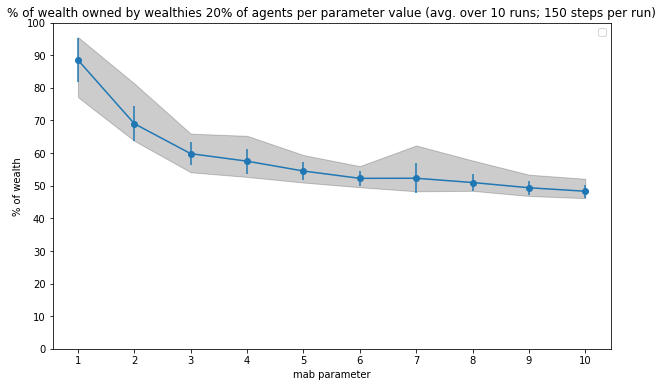

In [24]:
economic_model_inputs = [1,2,3,4,5,6,7,8,9,10]
parameter_space_economic_model(runs=10,nr_steps=150,N=500,wealth_falloff=0.5,mab=economic_model_inputs,defect_payoff=2,
                update_prob=0.05,inter_threshold=0.2, enforcement_prob=0.2, nb_parameter='fraction')

In [ ]:
economic_model_inputs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
parameter_space_economic_model(runs=10,nr_steps=150,N=500,wealth_falloff=0.5,mab=3,defect_payoff=2,
                update_prob=0.05,inter_threshold=economic_model_inputs, enforcement_prob=0.1, nb_parameter='fraction')